## Importing the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import investpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler

In [32]:
%matplotlib inline

## Getting data using investpy

In [2]:
df = investpy.get_stock_historical_data(stock='INFY',
                                        country='India',
                                        from_date='01/01/2010',
                                        to_date='31/12/2020')

## Data Preprocessing

In [3]:
df.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2010-01-04,323.69,326.17,321.87,324.01,4069264,INR
2010-01-05,324.93,326.26,322.46,325.10,6895528,INR
2010-01-06,332.74,332.74,319.36,320.35,6817288,INR
2010-01-07,320.79,320.79,312.31,313.16,10892600,INR
2010-01-08,312.41,312.94,304.84,305.61,12649312,INR


In [4]:
df.tail()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-12-24,1249.90,1249.90,1226.00,1236.05,7313885,INR
2020-12-28,1238.45,1248.00,1236.00,1240.30,4607051,INR
2020-12-29,1235.00,1254.45,1235.00,1250.30,6878105,INR
2020-12-30,1253.00,1253.30,1238.15,1246.80,5194690,INR
2020-12-31,1243.00,1258.40,1239.00,1255.80,7430470,INR


In [5]:
df = df.drop(['Open','Low','Volume','Currency','High'],axis=1)

In [6]:
df.head()

,Close
Date,
2010-01-04,324.01
2010-01-05,325.10
2010-01-06,320.35
2010-01-07,313.16
2010-01-08,305.61


In [7]:
df = df.sort_values('Date')

In [8]:
df.head()

,Close
Date,
2010-01-04,324.01
2010-01-05,325.10
2010-01-06,320.35
2010-01-07,313.16
2010-01-08,305.61


In [9]:
df.isnull().sum()

Close    0
dtype: int64

## Plotting the stock price data

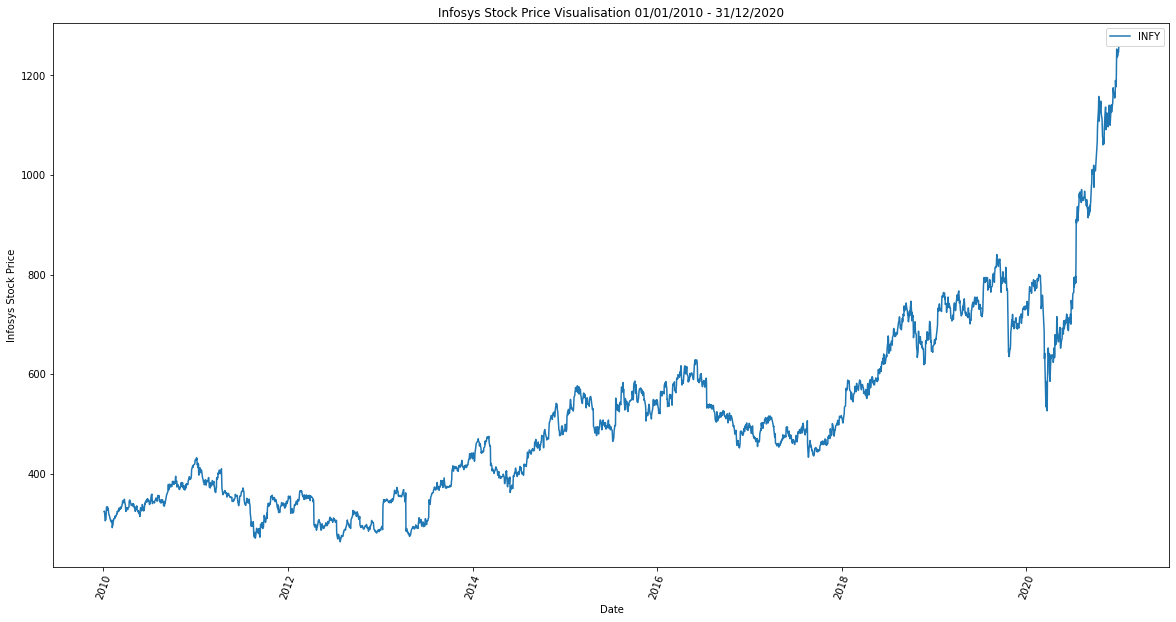

In [10]:
plt.figure(figsize=(20,10))
plt.plot(df.index, df['Close'])
plt.xlabel("Date")
plt.ylabel("Infosys Stock Price")
plt.xticks(rotation=70)
plt.legend(["INFY"])
plt.title("Infosys Stock Price Visualisation 01/01/2010 - 31/12/2020")
plt.savefig('Infosys_data_visualisation-1.png', bbox_inches='tight')

## Model Building Initial Steps

In [11]:
df1 = df.reset_index()

In [12]:
df1.head()

,Date,Close
0,2010-01-04,324.01
1,2010-01-05,325.10
2,2010-01-06,320.35
3,2010-01-07,313.16
4,2010-01-08,305.61


In [17]:
training_samples_count = df1.index[df1['Date'] == '01/01/2020']

In [18]:
print(training_samples_count)

Int64Index([2478], dtype='int64')


#### This implies that 2477 samples will be used for training and remaining will be used for prediction as the test set.

In [19]:
training_set = df.iloc[:2478].values
test_set = df.iloc[2478:].values

## Performing Feature Scaling

In [20]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
X_train = []
y_train = []
for i in range(60, 2478):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Training the Model

In [21]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the LSTM to the Training set
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
76/76 [==============================] - 6s 73ms/step - loss: 0.0135
Epoch 2/50
76/76 [==============================] - 6s 75ms/step - loss: 0.0039
Epoch 3/50
76/76 [==============================] - 6s 79ms/step - loss: 0.0034
Epoch 4/50
76/76 [==============================] - 6s 81ms/step - loss: 0.0034
Epoch 5/50
76/76 [==============================] - 6s 79ms/step - loss: 0.0031
Epoch 6/50
76/76 [==============================] - 6s 82ms/step - loss: 0.0028
Epoch 7/50
76/76 [==============================] - 6s 85ms/step - loss: 0.0027
Epoch 8/50
76/76 [==============================] - 7s 87ms/step - loss: 0.0028
Epoch 9/50
76/76 [==============================] - 7s 87ms/step - loss: 0.0024
Epoch 10/50
76/76 [==============================] - 7s 91ms/step - loss: 0.0026
Epoch 11/50
76/76 [==============================] - 7s 94ms/step - loss: 0.0025
Epoch 12/50
76/76 [==============================] - 7s 95ms/step - loss: 0.0024
Epoch 13/50
76/76 [==================

## Preparing for Testing and Predicting

In [22]:
dataset_train = df.iloc[:2478]
dataset_test = df.iloc[2478:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60,len(df)-len(dataset_train)+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(251, 60, 1)


In [23]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

## Visualisation of predicted results

In [24]:
dates = df1[2478:]['Date'].to_numpy()
dates = [str(date)[0:10] for date in dates]

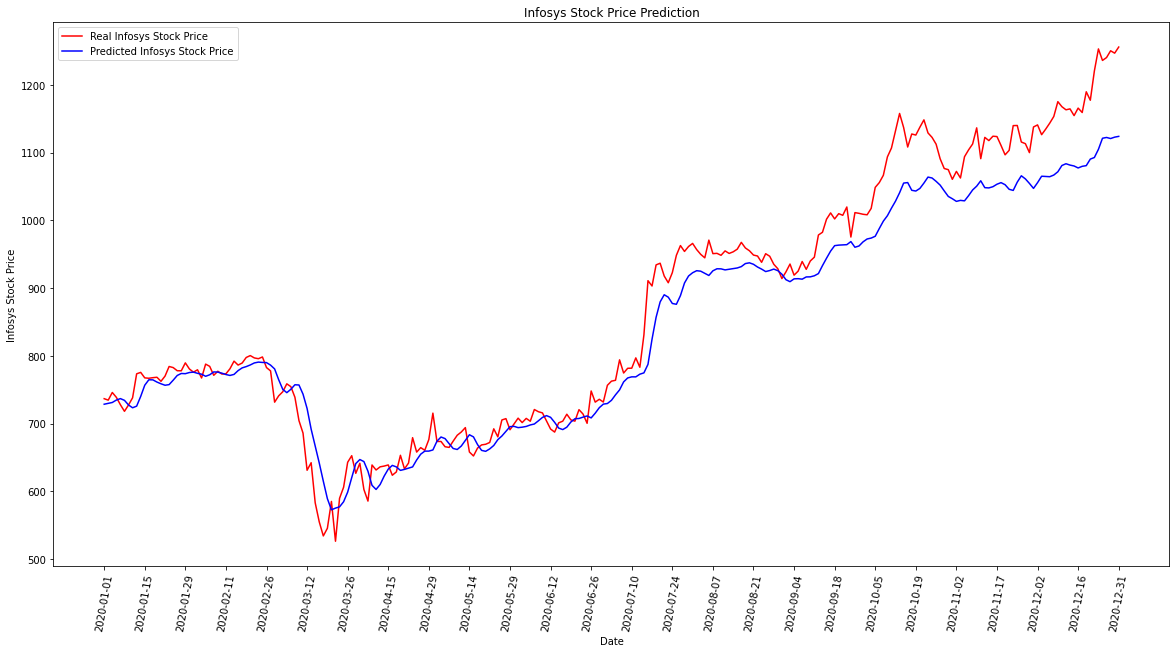

In [34]:
plt.figure(figsize=(20,10))
plt.plot(dates,dataset_test.values, color = 'red', label ='Real Infosys Stock Price')
plt.plot(dates,predicted_stock_price, color = 'blue', label = 'Predicted Infosys Stock Price')
plt.xticks(np.arange(0,len(dataset_test),10))
plt.title('Infosys Stock Price Prediction')
plt.xticks(rotation=80)
plt.xlabel('Date')
plt.ylabel('Infosys Stock Price')
plt.legend()
plt.savefig('Infosys_data_visualisation-2.png')
plt.show()